In [176]:
# Standard stack
import datetime
import pandas as pd
import numpy as np
from datetime import date
import re

# Visualization
from pandas_profiling import ProfileReport
#import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import tensorflow as tf
import tensorflow_decision_forests as tfdf
try:
    from wurlitzer import sys_pipes
except:
    from colabtools.googlelog import CaptureLog as sys_pipes

# Scikit-learn packages
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold

# display
from IPython.core.magic import register_line_magic
from IPython.display import Javascript

# no warnings
import warnings
warnings.filterwarnings('ignore')

In [177]:
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"
label = "outcome_type"

In [178]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
submission = pd.read_csv(TEST_PATH)

In [179]:
classes = train[label].unique().tolist()
print(f"Label classes: {classes}")

train[label] = train[label].map(classes.index)

Label classes: ['adoption', 'no outcome', 'transfer']


In [180]:
train.columns

Index(['id', 'age_upon_outcome', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'name', 'outcome_type', 'sex',
       'spay_neuter'],
      dtype='object')

In [181]:
test.columns

Index(['id', 'age_upon_outcome', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'name', 'sex', 'spay_neuter'],
      dtype='object')

# Train

In [182]:
def inpute_missing(dataset):
    """ 
    Edit this to fix nulls. Default version replaces all int/float with 0
    """
    for col in dataset.columns:
        if dataset[col].dtype not in [str, object]:
            dataset[col] = dataset[col].fillna(dataset[col].mean())
        elif col == 'name':
             dataset[col] = 'No Name'
    return dataset

train = inpute_missing(train)
test = inpute_missing(test)

In [183]:
def nlp_transforms(dataset):
    """ 
    NLP tranforms here. Default, None...
    """
    banned = ['brindle',
    'tabby',
    'merle',
    'torbie',
    'point',
    'smoke',
    'tiger',
    'tick'
    ]
    
    # Colors
    dataset['color'] = dataset['color'].str.lower()
    dataset['color'] = dataset['color'].str.replace('/', ' ')
    dataset['color'] = np.where(dataset['color'] == 'Tortie', 'Torbie', dataset['color'])
    
    dataset['color_type'] = 'Unknown'
    dataset['color_type'] = np.where(dataset['color'].str.contains('brindle'), "brindle", dataset['color_type'])
    dataset['color_type'] = np.where(dataset['color'].str.contains('tabby'), "tabby", dataset['color_type'])
    dataset['color_type'] = np.where(dataset['color'].str.contains('merle'), "merle", dataset['color_type'])
    dataset['color_type'] = np.where(dataset['color'].str.contains('torbie'), "torbie", dataset['color_type'])
    dataset['color_type'] = np.where(dataset['color'].str.contains('point'), "point", dataset['color_type'])
    dataset['color_type'] = np.where(dataset['color'].str.contains('smoke'), "smoke", dataset['color_type'])
    dataset['color_type'] = np.where(dataset['color'].str.contains('tiger'), "tiger", dataset['color_type'])
    dataset['color_type'] = np.where(dataset['color'].str.contains('tick'), "tick", dataset['color_type'])
    
    dataset['num_colors'] = dataset['color'].str.split('/').str.len()
    dataset['color_one'] = dataset['color'].apply(lambda x: x.split('/')[0])
    dataset['color_two'] = dataset['color'].apply(lambda x: x.split('/')[1] if len(x.split('/')) > 1 else 'None')

    dataset['color_one'] = dataset['color_one'].str.replace('/',' ')
    dataset['color_one'] = [' '.join([item for item in x.split() 
                       if item not in banned]) 
                       for x in dataset["color_one"]]

    dataset['color_two'] = dataset['color_two'].str.replace('/',' ')
    dataset['color_two'] = [' '.join([item for item in x.split() 
                       if item not in banned]) 
                       for x in dataset["color_two"]]\
    
    dataset['num_colors'] = np.where((dataset['color_one'] == 'tricolor') | (dataset['color_two'] == 'tricolor'), 3, dataset['num_colors'])
    
    # Breeds
    dataset['breed'] = dataset['breed'].str.lower()
    dataset['breed'] = dataset['breed'].str.replace('/', ' ')
    
    dataset['breed_one'] = dataset['breed'].apply(lambda x: x.split('/')[0])
    dataset['breed_two'] = dataset['breed'].apply(lambda x: x.split('/')[1] if len(x.split('/')) ==2 else dataset['breed_one'])
    dataset['breed_three'] = dataset['breed'].apply(lambda x: x.split('/')[2] if len(x.split('/')) ==3 else dataset['breed_one'])
    
    dataset['num_breed'] = dataset['breed'].str.split('/').str.len()
    dataset['mixed'] = np.where(dataset['breed'].str.contains('mix'), 1,0)
    dataset['mixed'] = np.where(dataset['num_breed'] > 1, 1 ,dataset['mixed'])
    return dataset

train = nlp_transforms(train)
test = nlp_transforms(test)

In [184]:
def computation_transforms(dataset):
    """ 
    New Feature Engineering. Default, None...
    """
    
    # Date stuff
    dataset['datetime'] = pd.to_datetime(dataset['datetime'])
    dataset['year'] = dataset['datetime'].dt.year
    dataset['month'] = dataset['datetime'].dt.month
    dataset['day'] = dataset['datetime'].dt.day
    dataset['hour'] = dataset['datetime'].dt.hour
    dataset['weekday'] = dataset['datetime'].dt.day_name()
    
    #age
    dataset['date_of_birth'] = pd.to_datetime(dataset['date_of_birth'])
    dataset['age'] = (dataset['datetime'] - dataset['date_of_birth']).dt.days
    dataset['birth_year'] = dataset['date_of_birth'].dt.year
    dataset['birth_month'] = dataset['date_of_birth'].dt.month
    # color??
    return dataset

train = computation_transforms(train)
test = computation_transforms(test)

# Train

In [185]:
train.head(1)

,id,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,name,outcome_type,sex,...,num_breed,mixed,year,month,day,hour,weekday,age,birth_year,birth_month
0,1265,2 years,Cat,russian blue mix,blue,2014-04-21,2016-08-05 14:15:00,No Name,0,Male,...,1,1,2016,8,5,14,Friday,837,2014,4


In [186]:
train.columns

Index(['id', 'age_upon_outcome', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'name', 'outcome_type', 'sex',
       'spay_neuter', 'color_type', 'num_colors', 'color_one', 'color_two',
       'breed_one', 'breed_two', 'breed_three', 'num_breed', 'mixed', 'year',
       'month', 'day', 'hour', 'weekday', 'age', 'birth_year', 'birth_month'],
      dtype='object')

In [187]:
train.shape

(54408, 28)

In [188]:
to_drop = ['id','age_upon_outcome','date_of_birth','datetime']
train = train.drop(to_drop,axis=1)
test = test.drop(to_drop,axis=1)

In [189]:
columns = train.columns.tolist()

In [190]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54408 entries, 0 to 54407
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   animal_type   54408 non-null  object
 1   breed         54408 non-null  object
 2   color         54408 non-null  object
 3   name          54408 non-null  object
 4   outcome_type  54408 non-null  int64 
 5   sex           54408 non-null  object
 6   spay_neuter   54408 non-null  object
 7   color_type    54408 non-null  object
 8   num_colors    54408 non-null  int64 
 9   color_one     54408 non-null  object
 10  color_two     54408 non-null  object
 11  breed_one     54408 non-null  object
 12  breed_two     54408 non-null  object
 13  breed_three   54408 non-null  object
 14  num_breed     54408 non-null  int64 
 15  mixed         54408 non-null  int64 
 16  year          54408 non-null  int64 
 17  month         54408 non-null  int64 
 18  day           54408 non-null  int64 
 19  hour

In [191]:
train.head(1)

,animal_type,breed,color,name,outcome_type,sex,spay_neuter,color_type,num_colors,color_one,...,num_breed,mixed,year,month,day,hour,weekday,age,birth_year,birth_month
0,Cat,russian blue mix,blue,No Name,0,Male,Fixed,Unknown,1,blue,...,1,1,2016,8,5,14,Friday,837,2014,4


In [156]:
columns

['animal_type',
 'breed',
 'color',
 'name',
 'outcome_type',
 'sex',
 'spay_neuter',
 'color_type',
 'num_colors',
 'color_one',
 'color_two',
 'breed_one',
 'breed_two',
 'breed_three',
 'num_breed',
 'mixed',
 'year',
 'month',
 'day',
 'hour',
 'weekday',
 'age',
 'birth_year',
 'birth_month']

In [218]:
def prepare_dataset(data):
    
    features = {"breed" : tf.strings.split(data["breed"]),
                #"color" : tf.strings.split(data["color"]),
                #"name" : tf.strings.split(data["name"]),
                #"sex" : data["sex"],
                #"num_breed" : data["num_breed"],
                #"year" : data["year"],
                #"month" : data["month"],
                #"day" : data["day"],
                #"hour" : data["hour"],
                #"weekday" : data["weekday"],
                #"age" : data["age"],
                #"birth_year" : data["age"],
                #"birth_month" : data["birth_month"]
               }
    
    try:
        label = data['outcome_type']
        output = features,label
    except:
        output = features
    
    return output

In [219]:
X_train, X_test = train_test_split(train,test_size=0.2, random_state=42)

columns = train.columns.tolist()
#columns = ['age','outcome_type']
train_dataframe = X_train[columns]
train_dataframe = train_dataframe.to_dict('list')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataframe)

test_dataframe = X_test[columns]
test_dataframe = test_dataframe.to_dict('list')
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataframe)



train_ds = train_dataset.batch(64).map(prepare_dataset)
test_ds = test_dataset.batch(64).map(prepare_dataset)

In [241]:
model_1 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1",
                                              num_trees=40)
model_1.compile(metrics=["accuracy"])
model_1.fit(x=train_ds)

681/681 [==============================] - 0s 467us/step


In [242]:
#logs

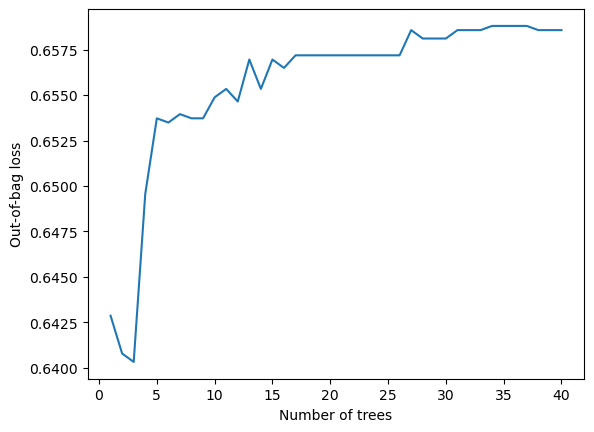

In [243]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag loss")
plt.show()

In [244]:
# all features
evaluation = model_1.evaluate(test_ds)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")


171/171 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.6570
BinaryCrossentropyloss: 0.0
Accuracy: 0.6570483446121216


In [227]:
#model_1.summary()

In [223]:
# only breed
evaluation = model_1.evaluate(test_ds)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

171/171 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.6501
BinaryCrossentropyloss: 0.0
Accuracy: 0.6500643491744995


In [195]:
## Old Model
evaluation

{'rf_baselines': {'loss': 0.0, 'accuracy': 0.8247565031051636},
 'rf_tune1': {'loss': 0.0, 'accuracy': 0.8263186812400818},
 'gbt_baselines': {'loss': 0.0, 'accuracy': 0.8265025019645691},
 'gbt_tune1': {'loss': 0.0, 'accuracy': 0.8265025019645691}}

In [169]:
evaluation

{'gbt_tune1': {'loss': 0.0, 'accuracy': 0.8293512463569641}}

# Train on Entire Dataset


In [245]:
train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=label)
# A more complex, but possibly, more accurate model.
#models = {
    #'rf_baselines': tfdf.keras.RandomForestModel(),
    #'rf_tune1': tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task = tfdf.keras.Task.REGRESSION),
    #'gbt_baselines': tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION),
#    'gbt_tune1': tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
#    }

models['gbt_tune1'].compile(metrics=["accuracy"])
models['gbt_tune1'].fit(x=train_tf)

851/851 [==============================] - 1s 1ms/step


# Predictions

In [246]:
models

{'rf_baselines': <tensorflow_decision_forests.keras.RandomForestModel at 0x7f50273560a0>,
 'rf_tune1': <tensorflow_decision_forests.keras.RandomForestModel at 0x7f5027356370>,
 'gbt_baselines': <tensorflow_decision_forests.keras.GradientBoostedTreesModel at 0x7f5026cb9ac0>,
 'gbt_tune1': <tensorflow_decision_forests.keras.GradientBoostedTreesModel at 0x7f5027338f70>}

In [304]:
scores = models['gbt_tune1'].predict(predictions)

In [305]:
#Label classes: ['adoption', 'no outcome', 'transfer']

In [306]:
scores

array([[8.7180000e-04, 9.9736279e-01, 1.7653710e-03],
       [2.0946354e-02, 7.1948725e-01, 2.5956640e-01],
       [9.3595344e-01, 3.3668408e-03, 6.0679663e-02],
       ...,
       [3.3661008e-01, 3.5512988e-02, 6.2787688e-01],
       [9.6797407e-01, 6.9470480e-03, 2.5078943e-02],
       [1.5179572e-01, 8.3186381e-02, 7.6501787e-01]], dtype=float32)

In [307]:
temp = pd.DataFrame(data=scores, columns=["adoption", "no outcome","transfer"])

In [308]:
temp['id'] = submission.id

In [309]:
temp = temp[['id','adoption','no outcome','transfer']]

In [310]:
temp

,id,adoption,no outcome,transfer
0,67473,0.000872,0.997363,0.001765
1,4629,0.020946,0.719487,0.259566
2,13914,0.935953,0.003367,0.060680
3,53131,0.093944,0.219680,0.686376
4,57800,0.585817,0.039921,0.374262
...,...,...,...,...
23312,9347,0.903591,0.038790,0.057620
23313,3781,0.004891,0.022325,0.972784
23314,74693,0.336610,0.035513,0.627877
23315,44987,0.967974,0.006947,0.025079


In [311]:
temp['no outcome'] = np.where(temp['no outcome'] > .96, 1, temp['no outcome'])
temp['adoption'] = np.where(temp['no outcome'] == 1, 0, temp['adoption'])
temp['transfer'] = np.where(temp['no outcome'] == 1, 0, temp['transfer'])

In [312]:
temp['adoption'] = np.where(temp['adoption'] > .96, 1, temp['adoption'])
temp['no outcome'] = np.where(temp['adoption'] == 1, 0, temp['no outcome'])
temp['transfer'] = np.where(temp['adoption'] == 1, 0, temp['transfer'])

In [313]:
temp['transfer'] = np.where(temp['transfer'] > .96, 1, temp['transfer'])
temp['adoption'] = np.where(temp['transfer'] == 1, 0, temp['adoption'])
temp['no outcome'] = np.where(temp['transfer'] == 1, 0, temp['no outcome'])

In [314]:
temp.to_csv('submission.csv', index=False)

In [316]:
!kaggle competitions submit -c sliced-s01e10-playoffs-2 -f submission.csv -m "Best With Names with outcome updates"

100%|█████████████████████████████████████████| 779k/779k [00:00<00:00, 850kB/s]
400 - Bad Request
